In [18]:
from pathlib import Path
import sys
from collections import defaultdict
import torch
from torch.utils.tensorboard import SummaryWriter
from rl_envs.gym_grid_world_env import GridWorldEnv
import numpy as np
from tools.helper import *
# from rl_envs.episodic_grid_world_env import EpisodicGridWorldEnv
# from rl_envs.grid_world_env import GridWorldEnv
from ReplayMemory import *
from agents.DQN_exact_book import DeepQLearningAgent
from agents.Q_Learning import QLearningAgent 
from torch.utils import data
%load_ext autoreload 
# %aimport rl_envs.grid_world_env

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
BATCHSIZE = 100
LEARN_RATE = 0.0015  # change to 0.001
RANDOM_POLICY_STATE_VALUE = [
    [-3.8, -3.8, -3.6, -3.1, -3.2],
    [-3.8, -3.8, -3.8, -3.1, -2.9],
    [-3.6, -3.9, -3.4, -3.2, -2.9],
    [-3.9, -3.6, -3.4, -2.9, -3.2],
    [-4.5, -4.2, -3.4, -3.4, -3.5],
] # state value 是和 policy 相关的, 我训练地越好当然就离 这个 random state value error 越远
# P.155 can find optimal state value about f_reward = -1

DISCOUNTED_FACTOR = 0.9
EPISODE_LEN = 5000

FORBIDDEN_REWARD = -10
HITWALL_REWARD = -10
TARGET_REWARD = 1

In [20]:

# def state_normalize(state, height, width):
#     # normalize each to [0,1]
#     return (state[0]/(height-1),state[1]/(width-1))

def calculate_state_value_error(env: GridWorldEnv, agent: DeepQLearningAgent, ground_truth_state_value):
    # offline policy have 2 policies
    # 用 mean Q 来当 state value 就是 Behavior policy, 或者用 max Q 就是用得到的 main policy
    # 或许用 main 更合理, 因为 v 值是对 policy 的一种衡量
    with torch.no_grad():
        state_value_error = 0
        V = {}
        for i in range(env.height):
            for j in range(env.width):
                # state = torch.tensor(
                #     agent.state_normalize((i, j), env.height, env.width),
                #     dtype=torch.float,
                # ).unsqueeze(0)
                state = torch.tensor((i,j), dtype=torch.float).unsqueeze(0)
                q_values = []
                for action_ind in range(agent.action_space):
                    action = torch.tensor(action_ind, dtype=torch.float).view(-1, 1)
                    sa_pair = torch.cat([state, action], dim=1)
                    q_value = agent.call_policy_net(sa_pair)
                    q_values.append(q_value.item())
                state_value = max(q_values)
                state_value_error += abs(state_value - ground_truth_state_value[i][j])
                V[(i, j)] = state_value
    return state_value_error, V


def obtain_episode(env: GridWorldEnv, length):
    f"""

    :param policy: 由指定策略产生episode
    :param start_state: 起始state
    :param start_action: 起始action
    :param length: episode 长度
    :return: 一个 state,action,reward,next_state,next_action 序列
    """
    episode = []
    obs, _ = env.reset()
    next_state = tuple(obs['agent'])
    while length > 0:
        length -= 1
        action = random.randint(0, 4)
        state = next_state
        obs, reward, terminated , truncated, info  = env.step(action)
        next_state = tuple(obs['agent'])
        episode.append(
            {
                "state": state,
                "action": action,
                "reward": reward,
                "next_state": next_state,   
            }
        )
    return episode


def get_data_iter(episode, batch_size=64, is_train=True):
    """构造一个PyTorch数据迭代器"""
    reward = []
    state_action = []
    next_state = []
    for i in range(len(episode)):
        reward.append(episode[i]["reward"])
        action = episode[i]["action"]
        y, x = episode[i]["state"]
        state_action.append((y, x, action))
        next_state.append(episode[i]["next_state"])
    reward = torch.tensor(reward, dtype=torch.float).reshape(-1, 1)
    state_action = torch.tensor(state_action, dtype=torch.float)
    next_state = torch.tensor(next_state, dtype=torch.float)
    data_arrays = (state_action, reward, next_state)
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train, drop_last=False)

In [21]:


env = GridWorldEnv(fixed_map = True, forbidden_grids=[(1,1),(1,2), (2,2),(3,1),(3,3),(4,1)], target_grids=[(3,2)], forbidden_reward=FORBIDDEN_REWARD, hit_wall_reward=HITWALL_REWARD, target_reward=TARGET_REWARD)
agent = DeepQLearningAgent(
    input_dim=3,
    output_dim=1,
    action_space = int(env.action_n),
    state_space= (env.height, env.width),
    lr=LEARN_RATE,
    discounted_factor=DISCOUNTED_FACTOR,
    hidden_dim=100
)
writer = SummaryWriter()

In [22]:

"""
calculate a ground truth state value, possibly use simply Q learning
"""
compare_agent = QLearningAgent(action_space_n=int(env.action_n), epsilon=0)
compare_agent.RUN(env)
Q = compare_agent.q
V = {}
for state in Q.keys():
    V[state] = max(Q[state])
print_by_dict(env, V)
print_actions(compare_agent, env)
ground_truth_state_value, _ = compute_state_value(env.height, env.width, env, compare_agent.policy)

print_by_dict(env, ground_truth_state_value)



[ 1.57 1.94 2.36 2.80 3.29 ]
[ 1.25 1.55 2.81 3.32 3.91 ]
[ 0.96 0.71 8.15 3.91 4.57 ]
[ 0.69 8.15 8.15 8.15 5.37 ]
[ 0.49 7.14 8.15 7.15 6.24 ]
[  →   →   →   ↓   ↓  ]
[  ↑   ↑   →   →   ↓  ]
[  ↑   ←   ↓   →   ↓  ]
[  ↑   →   ↺   ←   ↓  ]
[  ↑   →   ↑   ←   ←  ]
[ 3.49 3.87 4.30 4.78 5.31 ]
[ 3.14 3.49 4.78 5.31 5.90 ]
[ 2.82 2.54 10.00 5.90 6.56 ]
[ 2.54 10.00 10.00 10.00 7.29 ]
[ 2.29 9.00 10.00 9.00 8.10 ]


In [23]:
"""
generate samples to replay buffer
"""


# replay_buffer = ReplayMemory(2000)

# for _ in range(10):
#     state = env.reset()
#     for _ in range(200):
#         action = random.randint(0,4)
#         next_state, reward = env.step(state, action)
#         action = float(action)  / env.action_n # action also normalzie into [0,1]
#         replay_buffer.push(torch.tensor(agent.state_normalize(state, env.height, env.width), dtype=torch.float), torch.tensor(action, dtype=torch.float).unsqueeze(0), torch.tensor(reward, dtype=torch.float).unsqueeze(0), torch.tensor(agent.state_normalize(state, env.height, env.width), dtype=torch.float))
#         state = next_state

episode = obtain_episode(env, length=EPISODE_LEN)
date_iter = get_data_iter(episode, BATCHSIZE)

In [24]:
"""
perform DQN
"""
C = 50  # 0-50 感觉都差不多, 可能 15 更好 (但是或许是太小了, 反而 100-500 的模式或许才是对的) 1000>500?
# for C in [5]:
# for C in [1,2,3,5,8,13,21,34,50,80,100,200,300,500]:
# log_name = 'LR_{}_C_{}'.format(LEARN_RATE, C)
# writer = SummaryWriter(log_dir = 'runs/'+log_name)
epochs = 600

iter_counter = 0
for epoch in range(epochs):
    # for _ in range(50):
    for state_action, reward, next_state in date_iter:
        # transitions = replay_buffer.sample(BATCHSIZE)
        # batch = Transition(*zip(*transitions))
        # state = torch.stack(batch.state)
        # next_state = torch.stack(batch.next_state)
        # reward = torch.cat(batch.reward)
        # action_indices = torch.cat(batch.action)

        loss, q_value, target_value = agent.update_Q_network(
            state_action, reward, next_state
        )
        # copy target network every C=5 iteration
        # state_value_estimated = output.sum(dim=1) / env.action_n
        with torch.no_grad():
            writer.add_scalar(
                "TD error", (abs(q_value - target_value)).sum(), iter_counter
            )
            writer.add_scalar("Loss", loss.sum(), iter_counter)
            # writer.add_scalar(
            #     "State value error",
            #     calculate_state_value_error(env, agent, ground_truth_state_value)[0],
            #     iter_counter,
            # ) # 这一步恐怕耗时很高
            iter_counter += 1
        if iter_counter % C == 0:
            # agent.target_net.load_state_dict(agent.policy_net.state_dict())
            agent.sync_target_network()
    if epoch % 100 == 0:
        print_actions(agent, env, True)
        print(iter_counter)

writer.flush()
writer.close()
print_actions(agent, env, True)
print()


[  ↓   →   →   ←   ↺  ]
[  ↓   →   →   ↑   ←  ]
[  ↑   ↑   ↑   ↑   ←  ]
[  ←   ←   ←   ←   ←  ]
[  ↺   ↺   ↺   ↺   ↺  ]
50
[  →   →   →   ↓   ↓  ]
[  ↑   ↑   →   ↓   ↓  ]
[  ↑   ←   ↓   →   ↓  ]
[  ↑   →   ↺   ←   ↓  ]
[  ↑   →   ↑   ←   ←  ]
5050
[  →   →   →   ↓   ↓  ]
[  ↑   ↑   →   ↓   ↓  ]
[  ↑   ←   ↓   →   ↓  ]
[  ↑   →   ↺   ←   ↓  ]
[  ↑   →   ↑   ←   ←  ]
10050
[  →   →   →   ↓   ↓  ]
[  ↑   ↑   →   ↓   ↓  ]
[  ↑   ←   ↓   →   ↓  ]
[  ↑   →   ↺   ←   ↓  ]
[  ↑   →   ↑   ←   ←  ]
15050
[  →   →   →   ↓   ↓  ]
[  ↑   ↑   →   ↓   ↓  ]
[  ↑   ←   ↓   →   ↓  ]
[  ↺   →   ↺   ←   ↓  ]
[  ↺   →   ↑   ←   ←  ]
20050
[  →   →   →   →   ↓  ]
[  ↑   ↑   →   →   ↓  ]
[  ↑   ←   ↓   →   ↓  ]
[  ↑   →   ↺   ←   ↓  ]
[  ↑   →   ↑   ←   ←  ]
25050
[  →   →   →   ↓   ↓  ]
[  ↑   ↑   →   ↓   ↓  ]
[  ↑   ←   ↓   →   ↓  ]
[  ↑   →   ↺   ←   ↓  ]
[  ↑   →   ↑   ←   ←  ]
30050
[  →   →   →   ↓   ↓  ]
[  ↑   ↑   →   ↓   ↓  ]
[  ↑   ←   ↓   →   ↓  ]
[  ↑   →   ↺   ←   ↓  ]
[  ↑   →   ↑   ←   ←  ]
35

[  →   →   →   →   ↓  ]\
[  ↑   ↑   →   ↓   ↓  ]\
[  ↑   ←   ↓   →   ↓  ]\
[  ↑   →   ↺   ←   ↓  ]\
[  ↑   →   ↑   ←   ←  ]

In [25]:
torch.save(agent.policy_net.state_dict(), "./model_saves/book-version" + "_f_reward_" + str(FORBIDDEN_REWARD) + "_target_reward_" + str(TARGET_REWARD))

print(env)

print_actions(agent, env, True)

print()

V, i = compute_state_value(env.height, env.width, env, agent._policy_table)
print_by_dict(env, V)

<GridWorldEnv instance>
[  →   →   →   →   ↓  ]
[  ↑   ↑   →   →   ↓  ]
[  ↑   ←   ↓   →   ↓  ]
[  ↑   →   ↺   ←   ↓  ]
[  ↑   →   ↑   ←   ←  ]

[ 3.49 3.87 4.30 4.78 5.31 ]
[ 3.14 3.49 4.78 5.31 5.90 ]
[ 2.82 2.54 10.00 5.90 6.56 ]
[ 2.54 10.00 10.00 10.00 7.29 ]
[ 2.29 9.00 10.00 9.00 8.10 ]


In [26]:
# Q = defaultdict(lambda: [0 for _ in range(agent.action_space)])
# for i in range(env.height):
#     for j in range(env.width):
#         state = torch.tensor(
#             agent.state_normalize((i, j), env.height, env.width), dtype=torch.float
#         ).unsqueeze(0)
#         for action_ind in range(agent.action_space):
#             action = torch.tensor(
#                 action_ind / (agent.action_space - 1), dtype=torch.float
#             ).view(-1, 1)
#             sa_pair = torch.cat([state, action], dim=1)
#             q_value = agent.policy_net(sa_pair)
#             Q[(i, j)][action_ind] = q_value.item()
Q = agent.generate_Q_table(env.height, env.width)
print_by_dict(env, Q)

[ [2.907784938812256, 3.585057497024536, -6.879183769226074, -6.8773651123046875, 3.176605701446533] [-6.87418270111084, 4.032099723815918, -6.411780834197998, 3.2047181129455566, 3.5520052909851074] [-5.563724517822266, 4.437460899353027, -5.966802597045898, 3.580000162124634, 4.000100612640381] [4.8951215744018555, 4.920008659362793, -5.5546064376831055, 4.00408935546875, 4.447286128997803] [5.405356407165527, -5.065626621246338, -5.075366020202637, 4.432291030883789, 4.935450077056885] ]
[ [2.6817452907562256, -6.871672630310059, 3.1410486698150635, -7.112987995147705, 2.908738374710083] [2.415903329849243, -5.5677409172058105, 3.5840094089508057, 2.8810617923736572, -6.862002849578857] [-0.9077668190002441, 4.9137163162231445, 4.018818378448486, -6.861523151397705, -5.555211067199707] [5.423554420471191, 5.426836967468262, 4.437518119812012, -5.560434341430664, 4.910458087921143] [5.977440357208252, -4.56545877456665, 4.916426658630371, 4.916790008544922, 5.430118083953857] ]
[ [2.

In [27]:
"""
V 值没有完全收敛, 这是很正常的现象. 多训练几个 epoch 或许能使其完全收敛, 但是我认为没有特别的必要
"""
V = {}
for state in Q.keys():
    V[state] = max(Q[state])
print_by_dict(env, V)

[ 3.59 4.03 4.44 4.92 5.41 ]
[ 3.14 3.58 4.91 5.43 5.98 ]
[ 2.90 2.68 10.12 6.00 6.63 ]
[ 2.68 10.13 10.13 10.13 7.38 ]
[ 2.42 9.14 10.12 9.14 8.23 ]


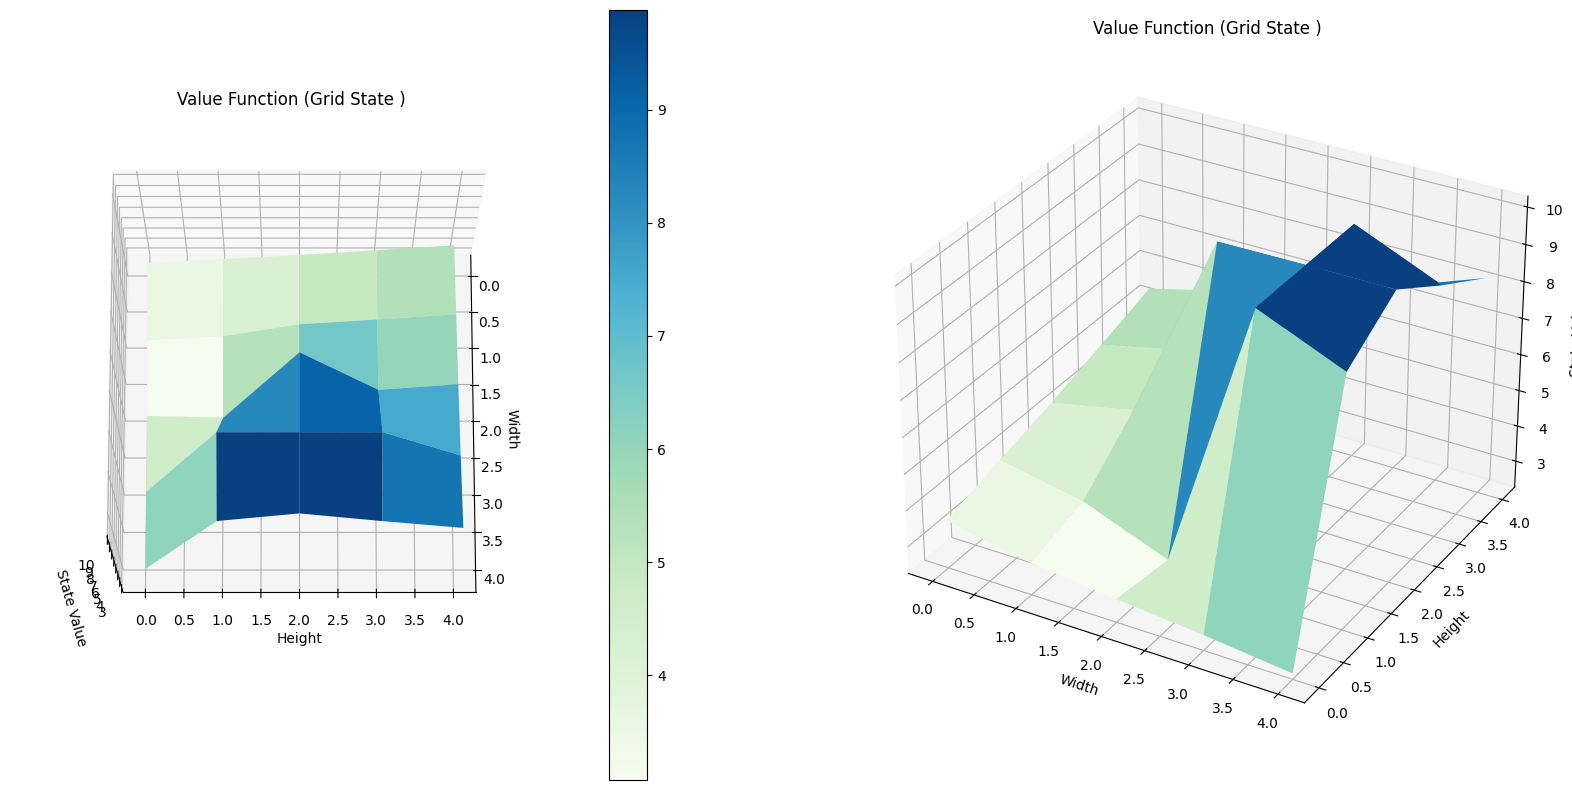

In [28]:
plot_value_function(V)